# Introduction

These notebooks will perform experiments and explore the sklearn implementations of algorithms that assume a linear relationship between the features and the target variable. After extensively exploring the performance of these algorithms for different data configurations (with varying number of features, number of observations, type of targets, type of processing), we will test the most meaningful findings with the house price competition data, trying to find our learning again in those settings.

For a broad introduction to linear models, please refer to https://en.wikipedia.org/wiki/Linear_regression or any good book of statistics. Here a quick summary

The main assumption of such models is that the target `y` is related with the explanatory variables as $$y = \alpha + \beta_1 x_1 + \dots + \beta_n x_n,$$
and our goal is to estimate the values of $\alpha$ and $\beta_i$.

The other assumptions for most of the models are
* Constant variance (homoscedasticity) of the errors, independently of the value of the variables. This assumption simplifies the computation.
* Independence of errors of the predicted target variable, which should not have a correlation
* No perfect multicollinearity between the variables
* The predictors are assumed to be error-free

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import make_exp, learning_curve

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/01_linear_models.csv'  # for storing results

In [2]:
numeric_pipe = Pipeline([('fs', df_p.feat_sel('numeric')),
                         ('imputer', df_p.df_imputer(strategy='median'))])


cat_pipe = Pipeline([('fs', df_p.feat_sel('category')),
                     ('imputer', df_p.df_imputer(strategy='most_frequent')), 
                     ('dummies', df_p.dummify())])

processing_pipe = df_p.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()), 
                  ('linear', LinearRegression())])

kfolds = KFold(10, shuffle=True, random_state=541)

The simplest LinearRegression can be implemented as above, we can quickly test it via the functions we developed in Notebook 02.

For example, we see that for a target generated by a linear function of the features we get a very good model

In [3]:
df = pd.read_csv('data/simulated/clean.csv')

df_train = df[[col for col in df.columns if not col.startswith('tar_') and 'unc' in col]].copy()

target = df['tar_lin_10']

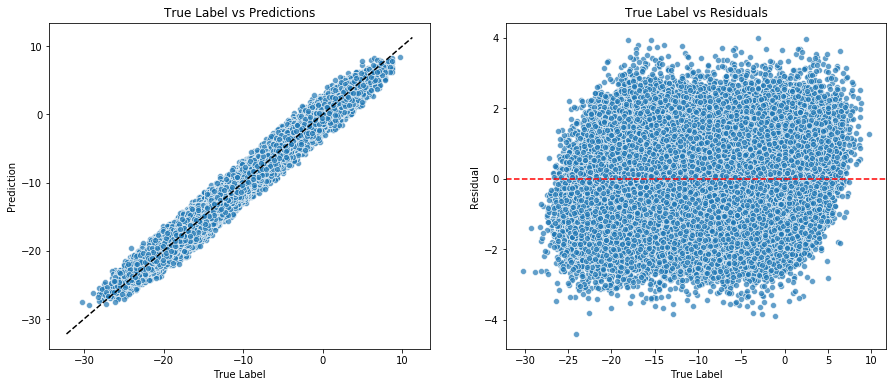

In [4]:
oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

However, we see that not necessarily we estimate the coefficients correctly

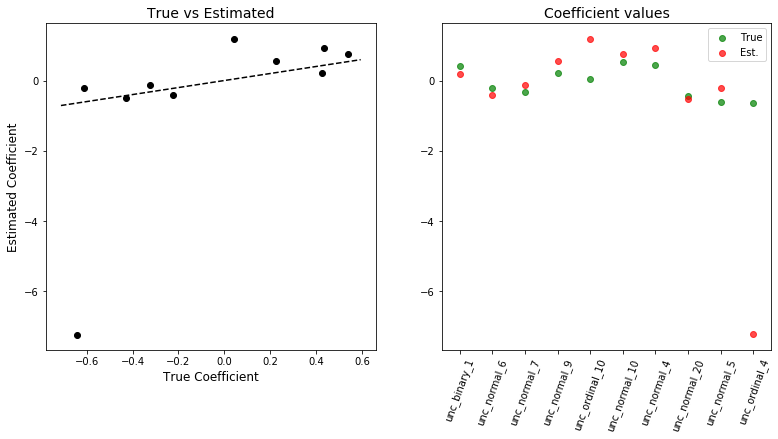

In [5]:
hyp.plot_coefficients('tar_lin_10', coefs_est)

In [6]:
res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_lin_10', variables='unc', instances=100000, verbose=True)

MAE: 		 0.79715
MSE: 		 0.99826
Max Error: 	 4.39629
Expl Variance: 	 0.98249


This is actually the effect of the scaler we used. The targets were not generated by first scaling the data and thus the true coefficients can be different.

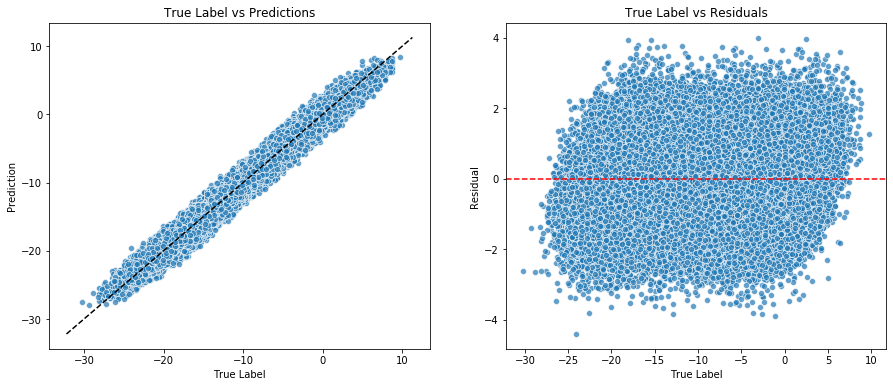

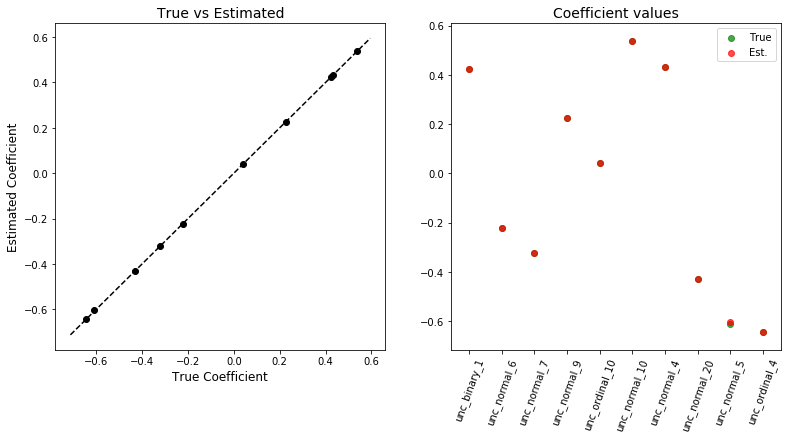

MAE: 		 0.79714
MSE: 		 0.99823
Max Error: 	 4.39341
Expl Variance: 	 0.98249


In [7]:
model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.dummify()),  # it does nothing, but guarantees that the other functions do not break
                  ('linear', LinearRegression())])

oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

hyp.plot_coefficients('tar_lin_10', coefs_est)

res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_lin_10', variables='unc', instances=100000, verbose=True)

On the other hand, we see that if the target is generated non-linearly, the model performs poorly

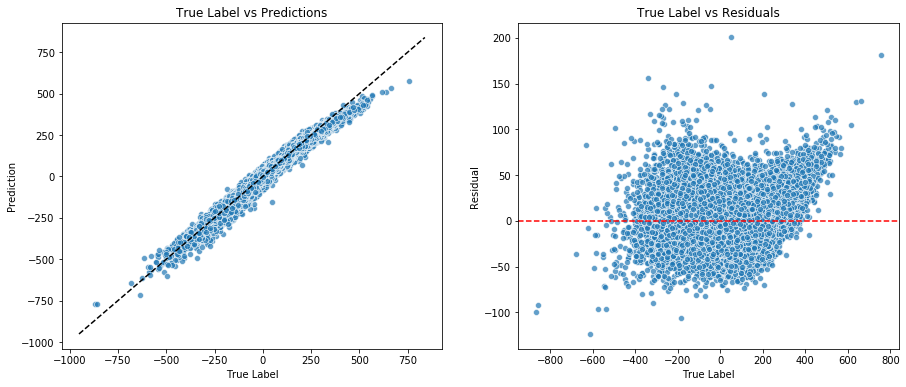

MAE: 		 12.68177
MSE: 		 297.82075
Max Error: 	 200.28833
Expl Variance: 	 0.97982


In [8]:
model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()),  # here we won't look at the coefficients, we can use the normal scaler
                  ('linear', LinearRegression())])

df_train = df[[col for col in df.columns if not col.startswith('tar_')]].copy()

target = df['tar_nonlin_10']

oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_nonlin_10', variables='All', instances=100000, verbose=True)

For each model, we will have a look at these metrics and store the results when needed. We will iterate on different data and model configurations to understand how all these moving parts are playing with one another.

## Side note on using scalers

The objective function of linear models (especially with regularization) assumes that the features are centered around 0 and have roughly the same scale. Therefore, **the correct procedure is to always scale your features**. This makes also the interpretation of the coefficients possible since we are then allowed to say that the variation of one feature by one unit has the same interpretation across the features and thus we can say something about the coefficients. Moreover, scaling the features often speeds up the learning process of our algorithms.

All that being said, we want to explore how different algorithms react in different situations and one way to judge that is to check how well the coefficients are estimated. Therefore, we will make an exception and **not use any scaler** every time we want to check the estimate of the coefficients, compromising a bit the performance and accuracy of the models to allow ourselves to check this aspect as well.

# Experiments

We have seen already that if the target is linearly generated, we can perfectly fit the data (please keep in mind that all the predictions and the scores are referring to the performance on a holdout set with a 10 fold CV scheme). The model has very few hyperparameters ([see the sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)) and we thus investigate the performance of the model when we change the input data.

In [9]:
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Linear functions, noise, correlation

In this section, we see how `LinearRegression` can fit data and predict a target variable generated by a linear relation.

First, we use a dataset of 100000 observations, 10 variables, all of which were used to generate the target without noise.

In [10]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('linear', LinearRegression())])
params = 'default'

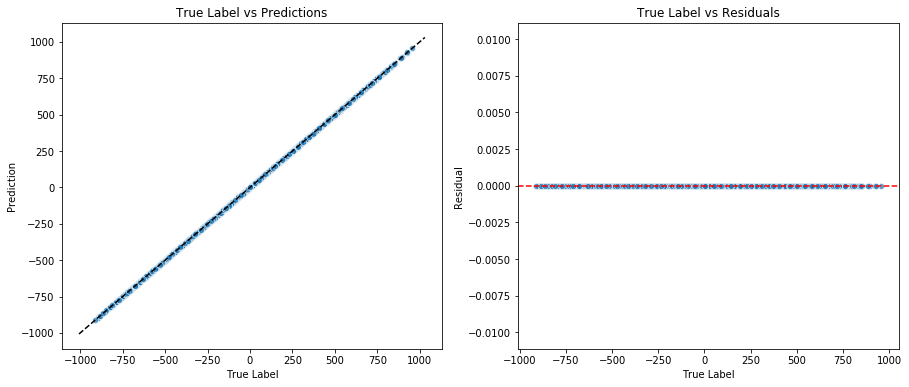

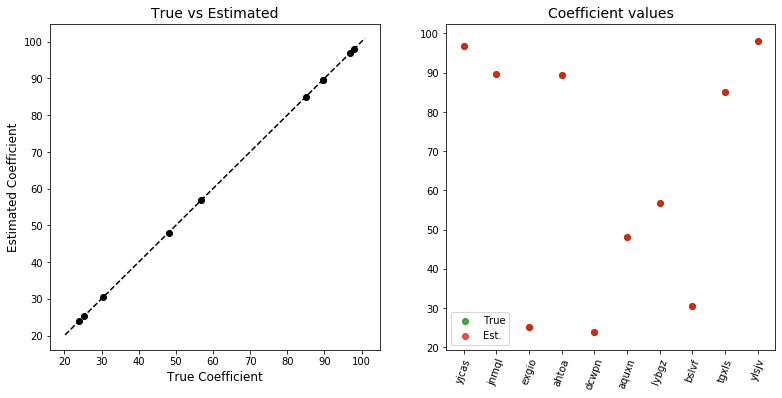

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [11]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

However, already using a target generated with some **noise** we notice a significant drop in performance

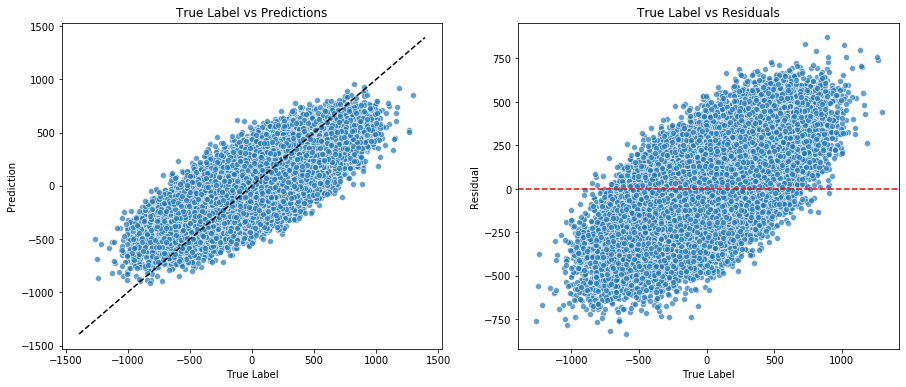

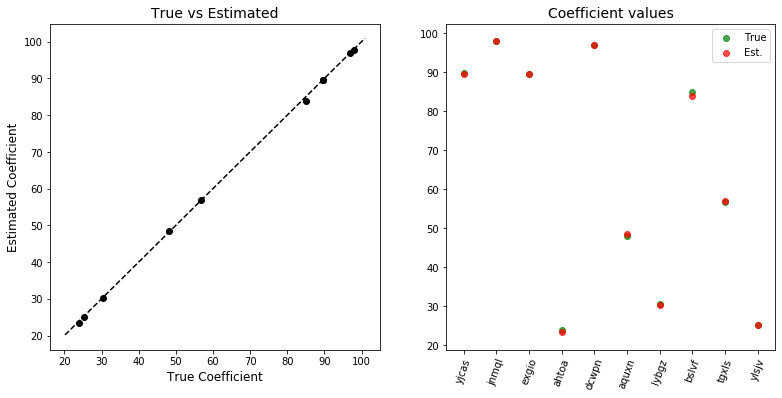

MAE: 		 159.15957
MSE: 		 39903.46378
Max Error: 	 870.78547
Expl Variance: 	 0.55337


In [12]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

Still a reasonably good estimation of the coefficients, something that deteriorates if we have more coefficients (for example, 65 informative features over 100 available)

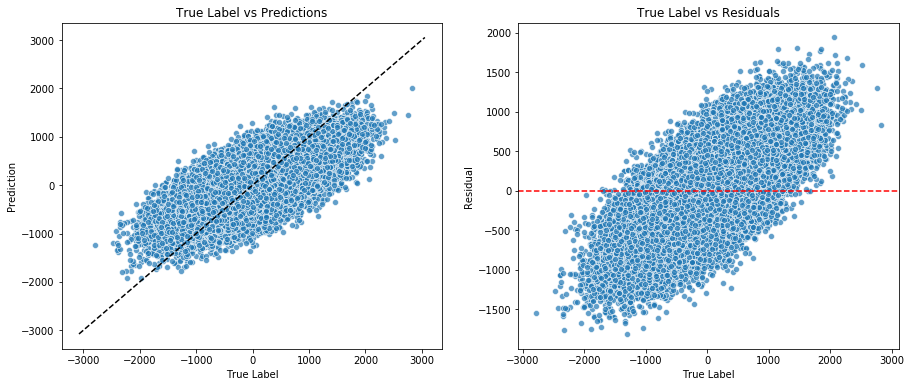

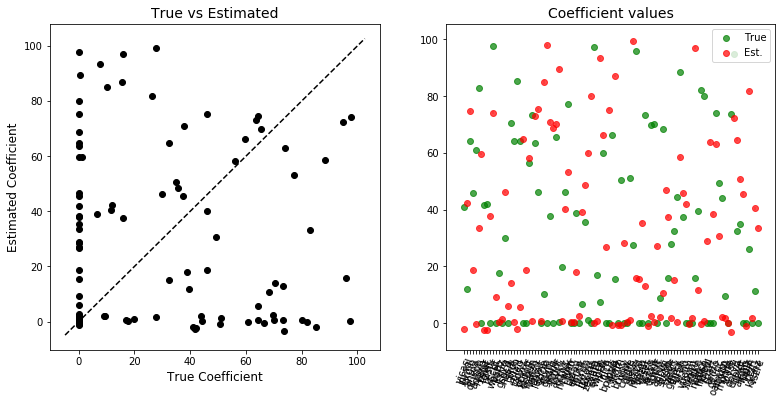

MAE: 		 359.51792
MSE: 		 202633.44246
Max Error: 	 1939.61267
Expl Variance: 	 0.48907


In [13]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

Curiously, if we introduce some correlation among the features we get again reasonable estimates of the coefficients

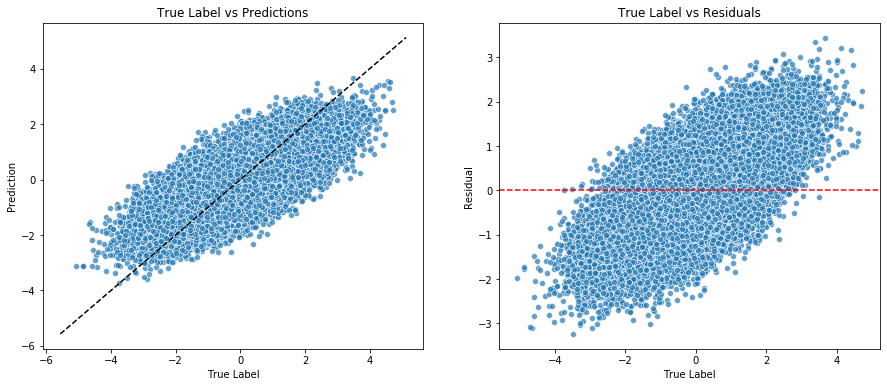

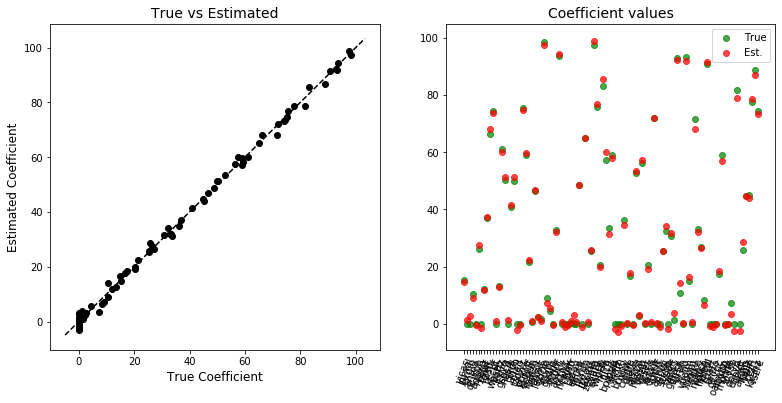

MAE: 		 0.63864
MSE: 		 0.63961
Max Error: 	 3.43738
Expl Variance: 	 0.53145


In [14]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise_rank.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

## Number of instances

If we vary the number of features, we notice interesting patterns. For example, for how much the model is (reasonably) not able to pick up a signal if there is noise, it would get a very similar result by using much fewer training instances and, by using them all, it learns the underlying relation at the best of its possibilities (as we have seen from the perfectly estimated coefficients)

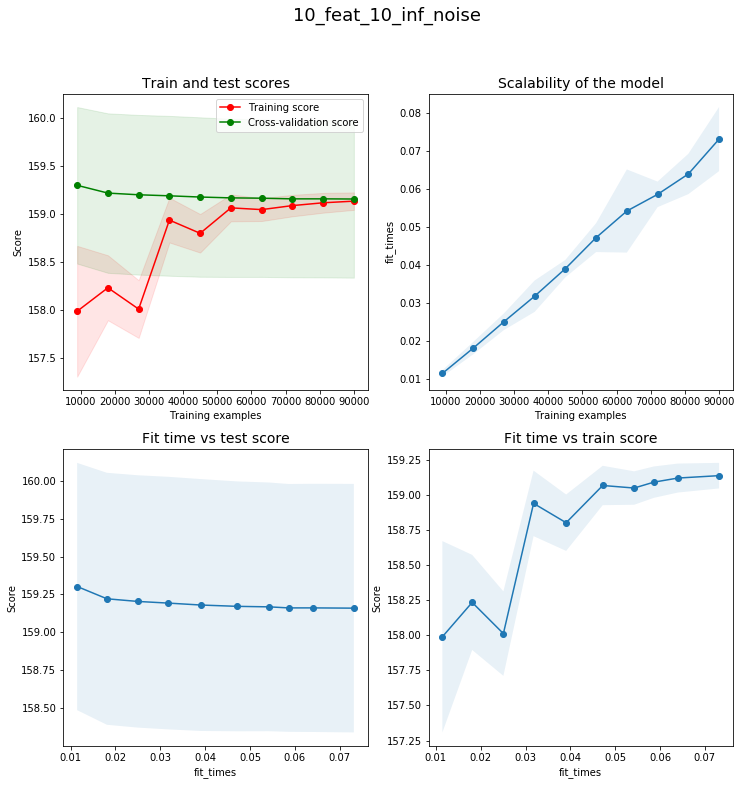

In [15]:
learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', kfolds=kfolds)

As it is expected, if we have more features, the model benefits more from a higher number of training instances.

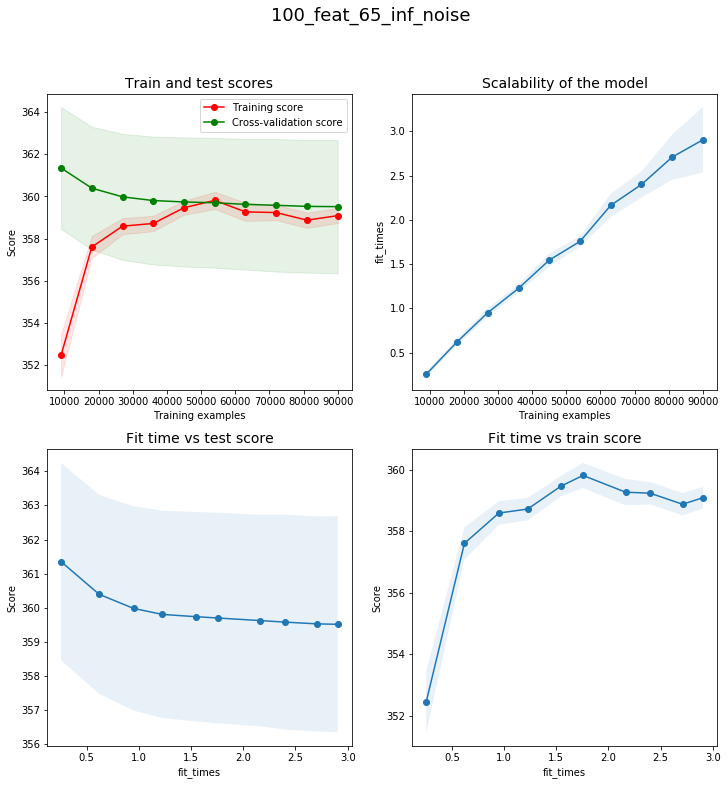

In [16]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', kfolds=kfolds)

We can then look at the results of our experiment if we limit the number of instances to a very low number and notice how the estimate of the coefficients, that was perfect before, deteriorates.

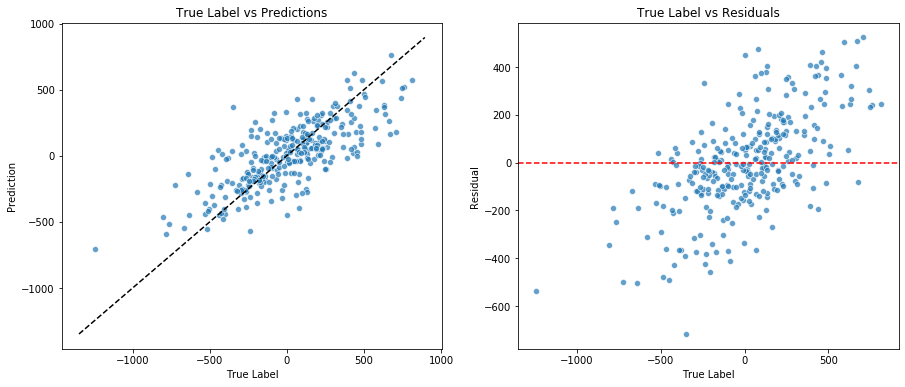

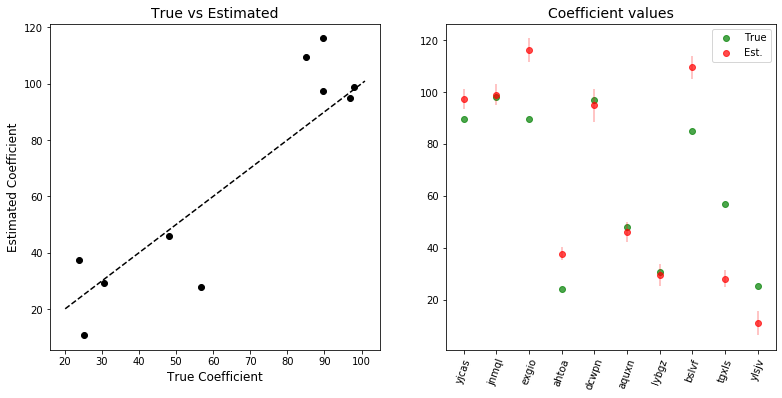

MAE: 		 155.8184
MSE: 		 42437.72838
Max Error: 	 717.28677
Expl Variance: 	 0.56696


In [17]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

### Good performance, bad coefficients

We have seen before that we can have a model that perfectly fits the data but estimates poorly the coefficients. Let's see how is this possible.

To do so, let's take a dataset without noise where the target was generated by a fraction of the total available features. Even though the prediction is perfect, the model is estimating a lot of coefficients as null that are not supposed to be 0 and giving non-null value to many other variables. In other words, a linear combination of variables can potentially substitute the effect that another variable is having on the target.

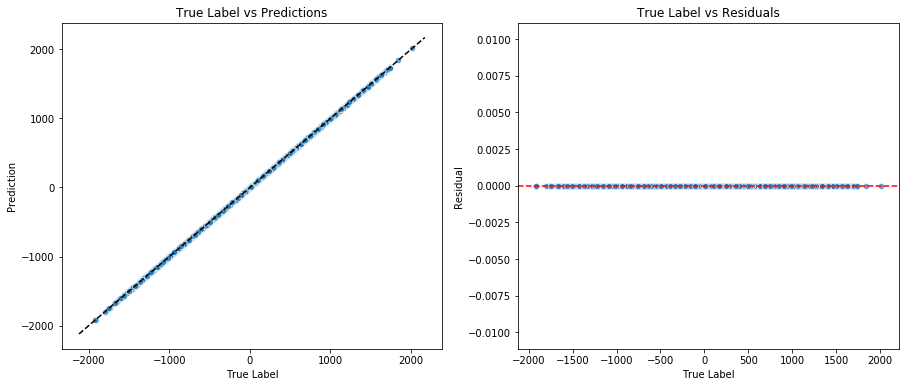

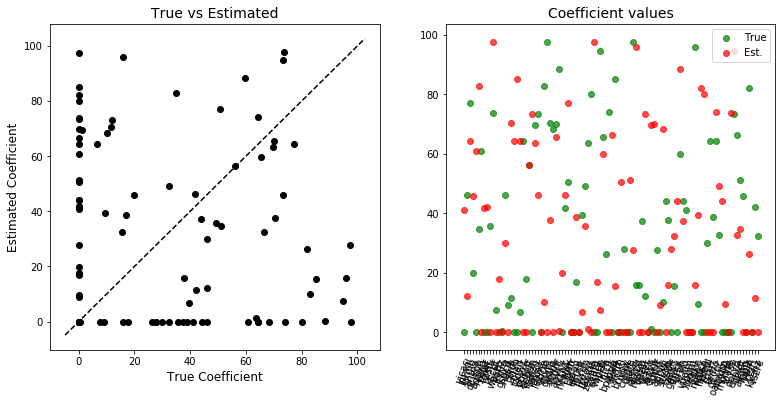

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [18]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

Interestingly enough, if we restrict the training variables to the ones that were actually used to generate the model, we still get the perfect score but not a better estimate for each coefficient, showing that the model is already struggling with picking up the signal of each feature.

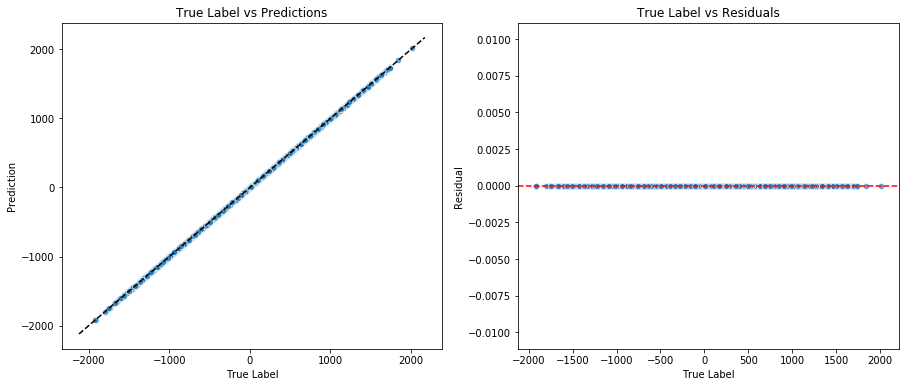

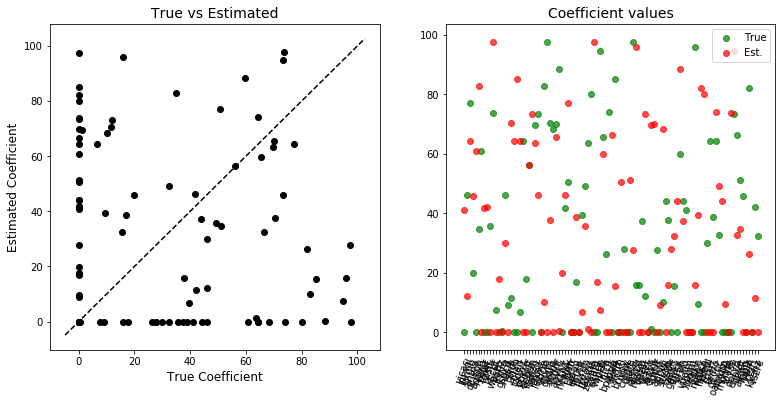

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [19]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_nonoise.csv', 
         target_name=None, 
         features='exact',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

# More complex datasets

Since the dataset generated by sklearn can be either too complicated or too simple for our experiments, we can test our algorithm on the data we generated in notebook 1.

## 100 features

We start with a target created by a linear combination of all **100 features** and we provide a dataset that contains them all. We expect a dependency on the number of training instances.

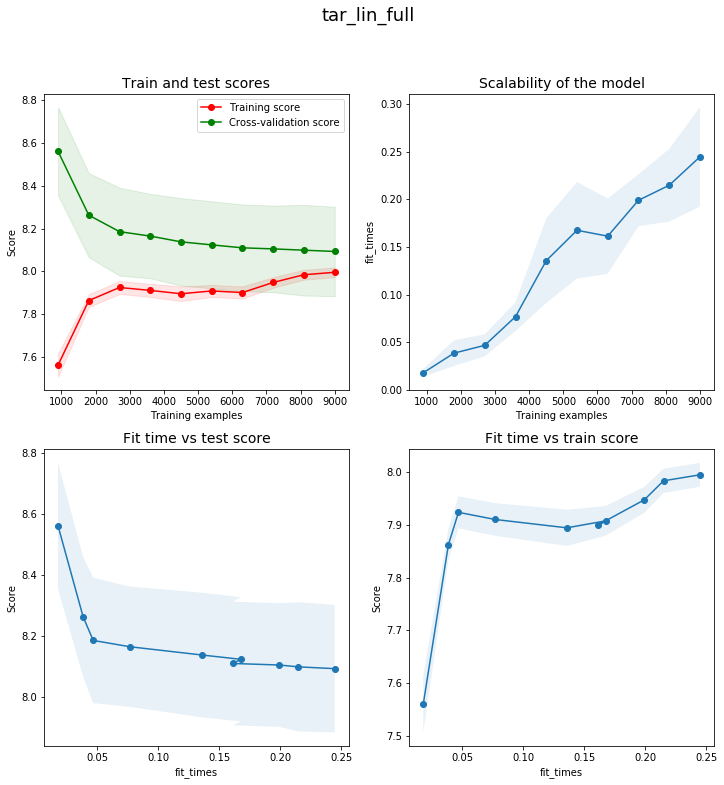

In [20]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000, kfolds=kfolds)

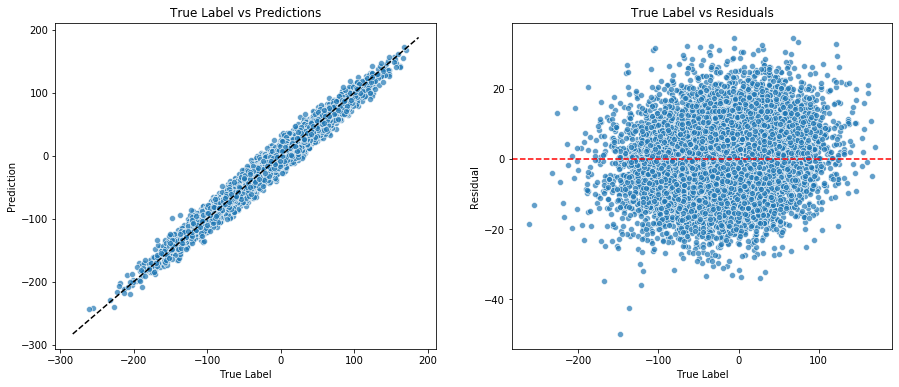

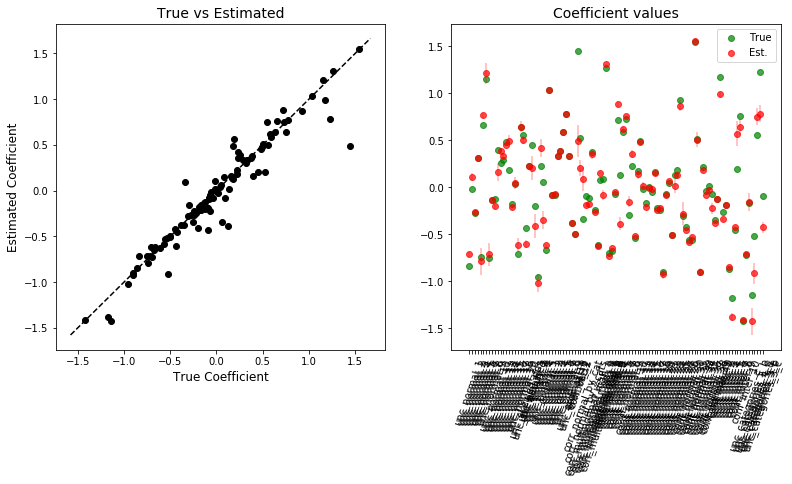

MAE: 		 7.94879
MSE: 		 99.28868
Max Error: 	 49.81762
Expl Variance: 	 0.97004


In [21]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

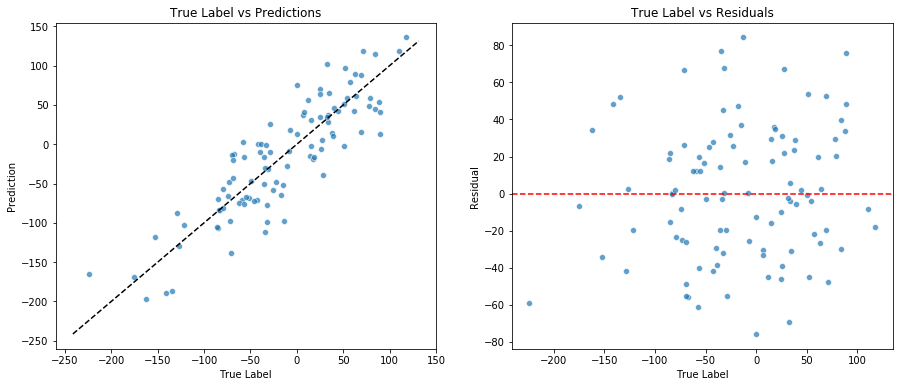

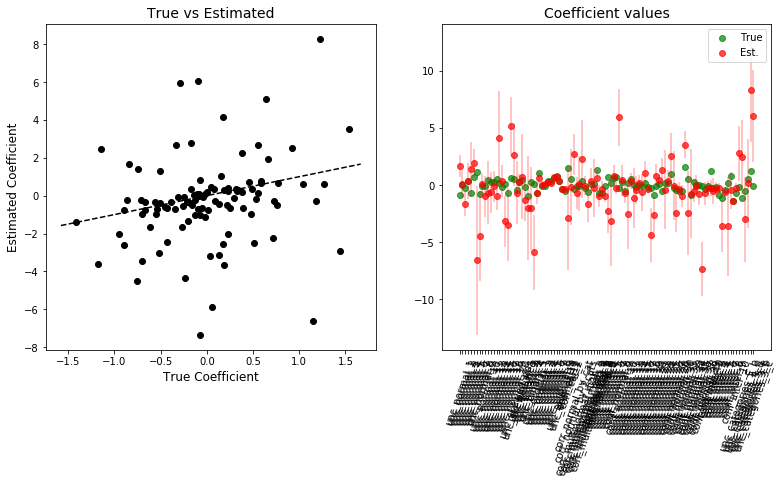

MAE: 		 29.54632
MSE: 		 1290.03545
Max Error: 	 84.28245
Expl Variance: 	 0.72121


In [22]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

With very few training instances the model is struggling quite a lot. We also observe that, **even though the score can get better with more observations, the estimate of the coefficients is not accurate for some coefficients**.

Alternatively, we can simulate what would happen if we **don't have all the features used to generate the target** (thus if there is some unobserved variable)

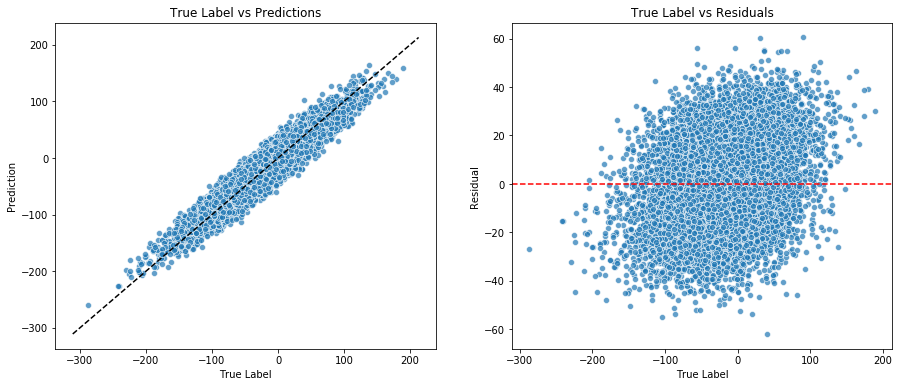

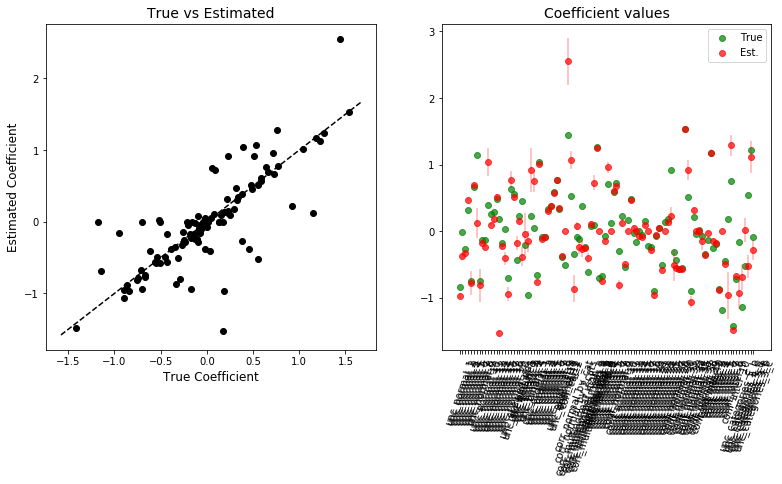

MAE: 		 15.7025
MSE: 		 359.35122
Max Error: 	 61.89974
Expl Variance: 	 0.89011


In [23]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

The coefficient plot fills the missing coefficients with a value of 0, therefore we can compare the estimates using all the features and only 90% of them and notice that some of the 'unobserved' ones happen to have a negative coefficient. We see those anomalous 3 dots in the mid-left of the first coefficient plot. We can then see how the rest of the coefficients adapted to compensate.

This random 10% of unobserved variables led to a nearly **doubled absolute error, much higher maximum error, and a drop of 8% in the explained variance**.

## 50 features

We can now simulate what would happen with a target generated by **50 features**. Here it might be interesting to see the dependency from the number of instances both if we just use the right 50 features or we use 50 additional useless features (but keep in mind that some of these additional features are interactions of the first 50).

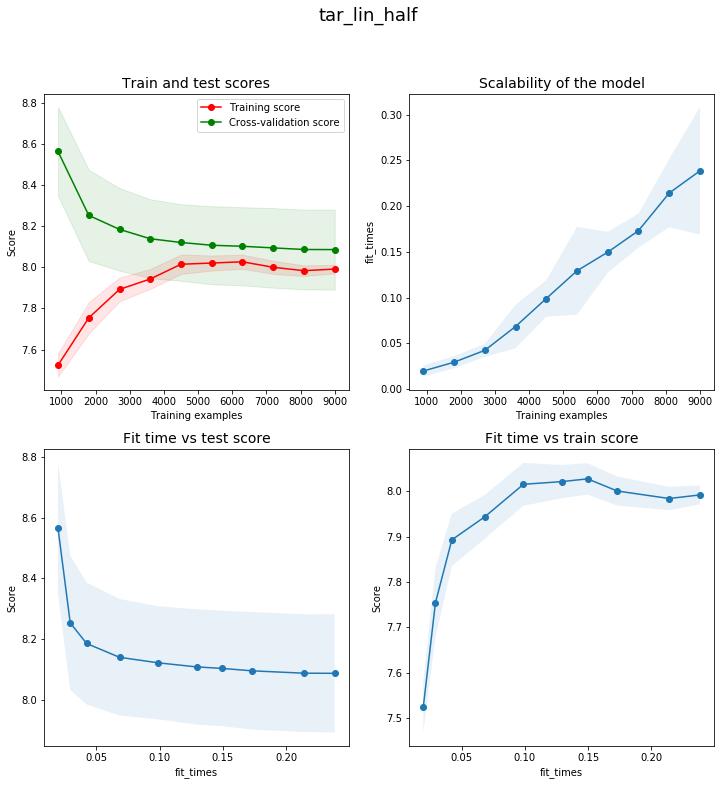

In [24]:
learning_curve(model, target_name='tar_lin_half', features='all', sample=10000, kfolds=kfolds)

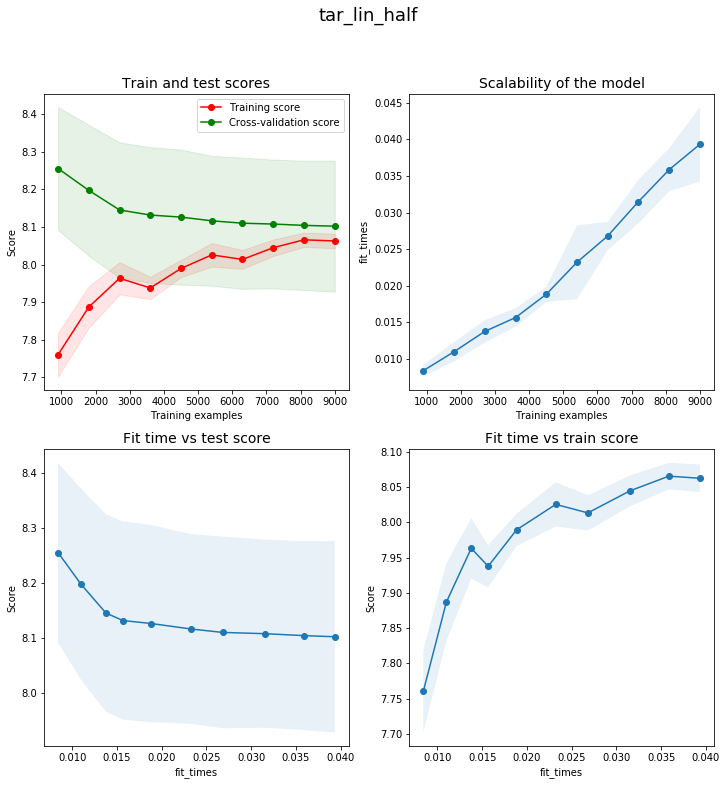

In [25]:
learning_curve(model, target_name='tar_lin_half', features='exact', sample=10000, kfolds=kfolds)

We see that the scalability of the model does not change, but the one using fewer features is obviously faster. In fact, **it scales linearly in the number of observations and quadratically in the number of features**, thus with twice as many features the model takes 4 times more time, as we can see from the plot on the top right. We also see that the model with all the features would benefit from additional data while the other one is already close to the best score it can achieve.

As a baseline, let's first see how the model learns when it trains with the exact features used to generate the target.

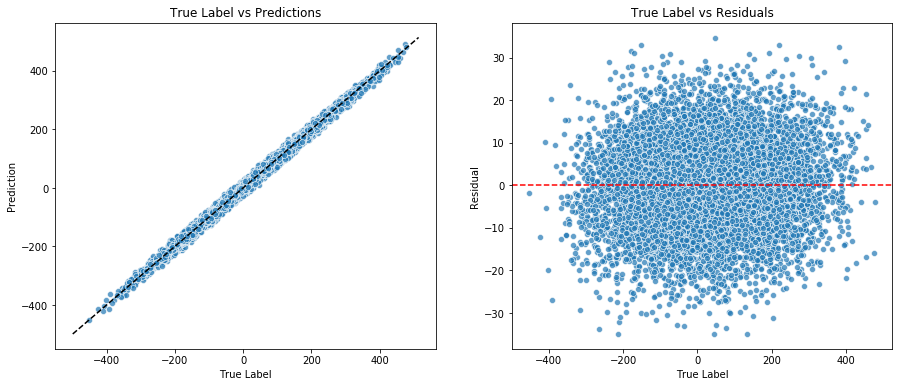

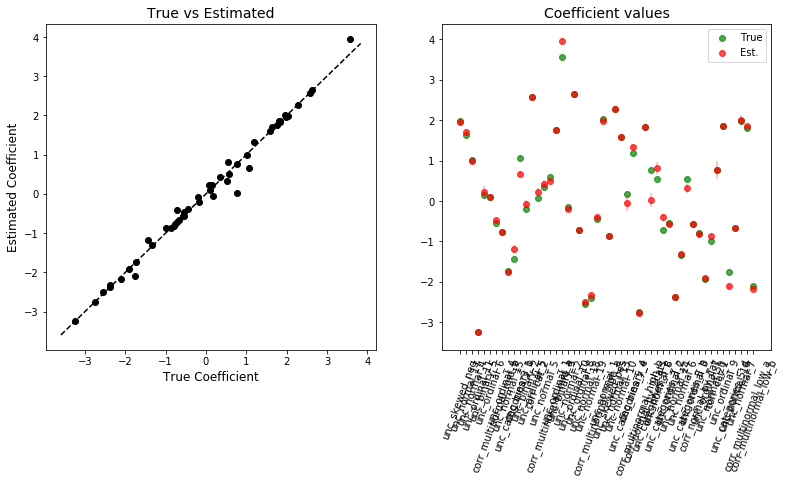

MAE: 		 7.99747
MSE: 		 100.07033
Max Error: 	 34.92779
Expl Variance: 	 0.99548


In [26]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

It is a very good model, most of the 50 coefficients are estimated correctly with very little variance from fold to fold and the predictions look very nice. By using all the 100k observations, we get very similar scores and better coefficients' estimates.

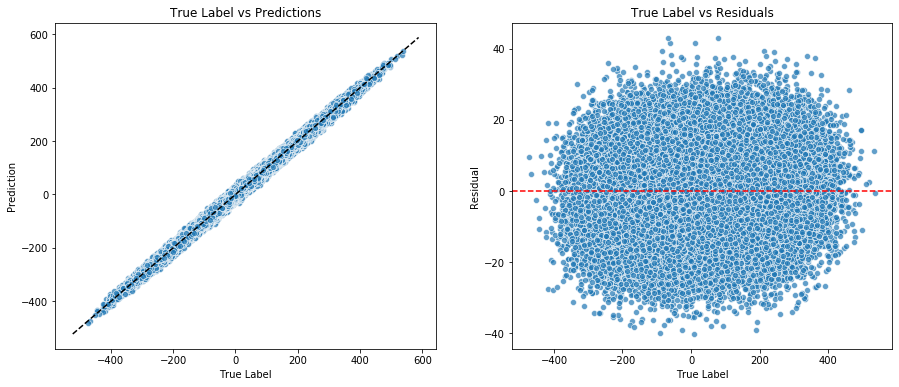

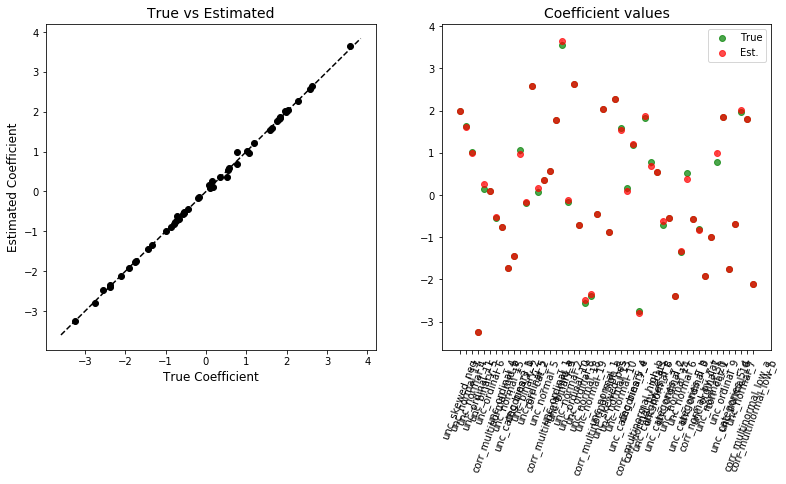

MAE: 		 7.99905
MSE: 		 100.43092
Max Error: 	 43.17173
Expl Variance: 	 0.99541


In [27]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=False, 
         store=False, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

On the other hand, with a very small number of observation we see a significant drop in perfomance

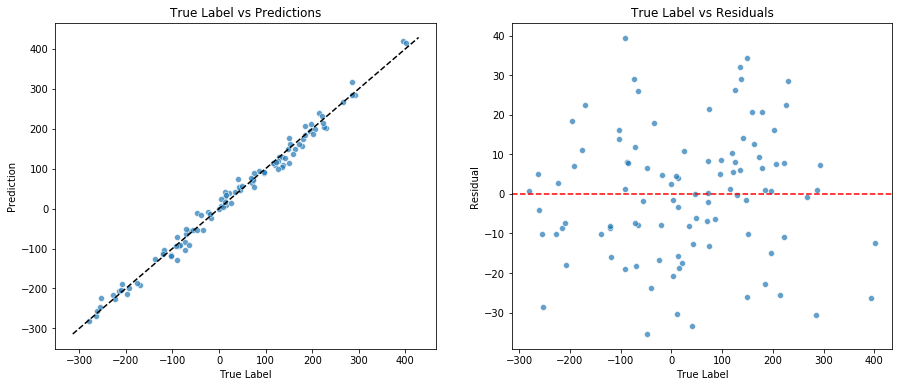

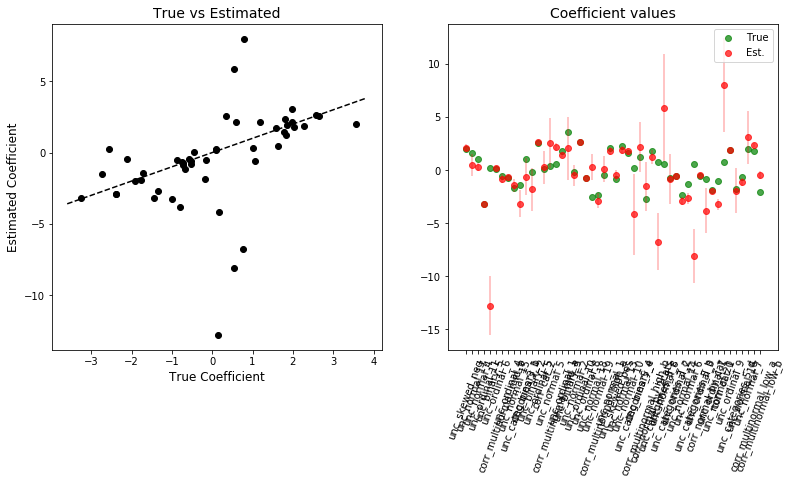

MAE: 		 12.91225
MSE: 		 260.52927
Max Error: 	 39.50202
Expl Variance: 	 0.98902


In [28]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

What happens then when we have more features than necessary? We expect the model to pick up the wrong signal more easily, thus a drop in perfomance and coefficients' estimate.

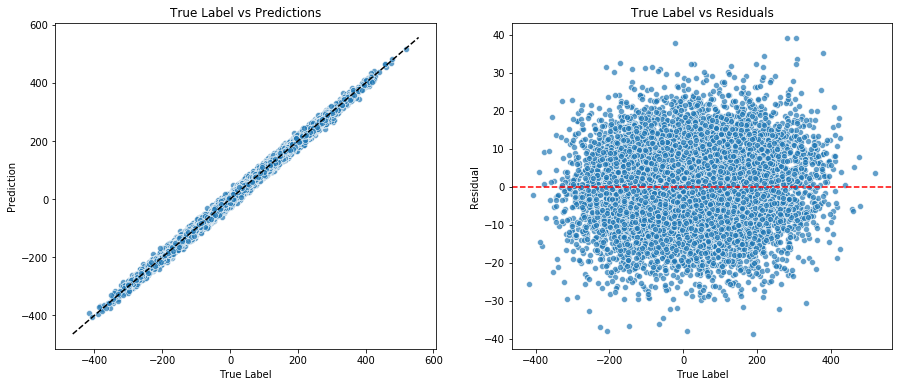

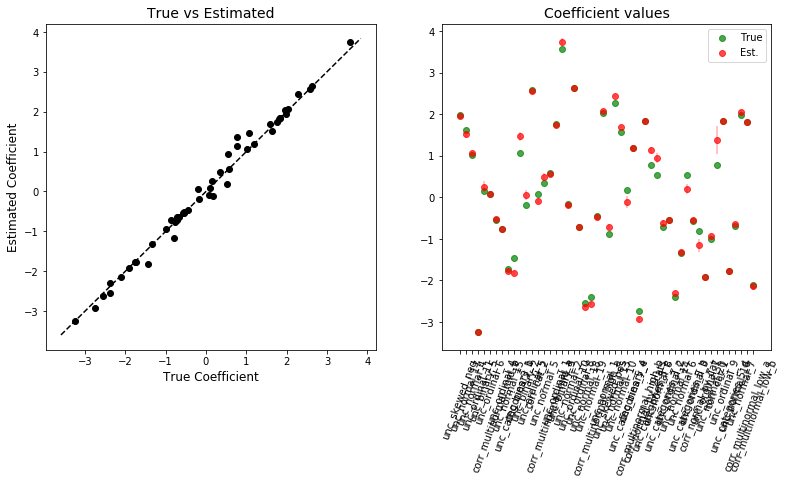

MAE: 		 8.0178
MSE: 		 101.70159
Max Error: 	 39.31458
Expl Variance: 	 0.99532


In [29]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

The performance doesn't drop much and the estimated coefficients are very similar to the previous ones, although less precise as expected. However, with only 100 training instances, the performance gets much worse, telling us that, if we have the right features, having more training instances is more important than feature selection.

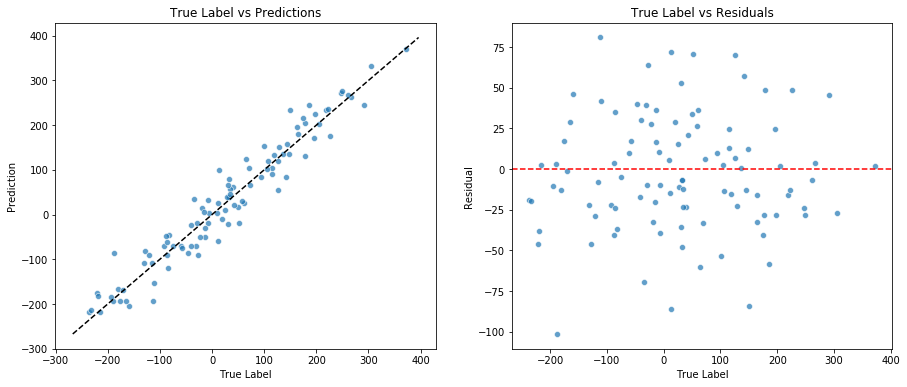

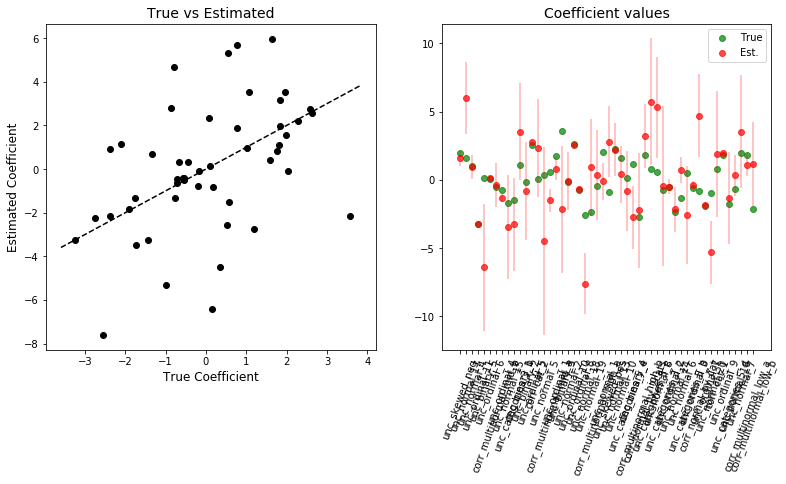

MAE: 		 28.58834
MSE: 		 1284.08947
Max Error: 	 101.45888
Expl Variance: 	 0.93253


In [30]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

Once again, we can simulate the presence of **unobserved variables**. This time we can do so both with and without the presence of other variables unrelated to the target.

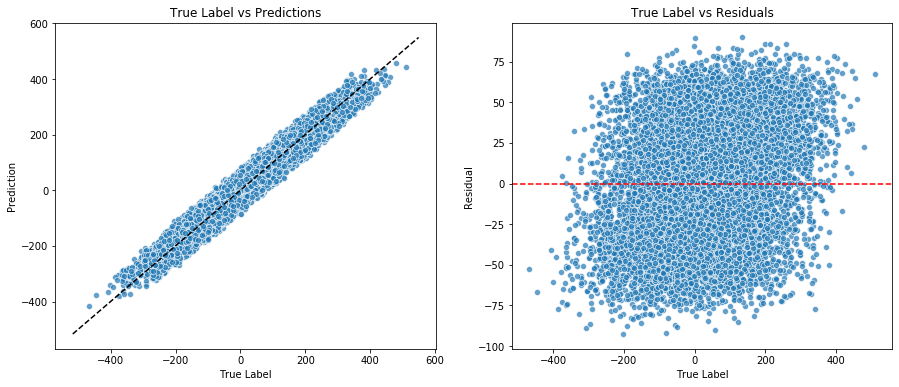

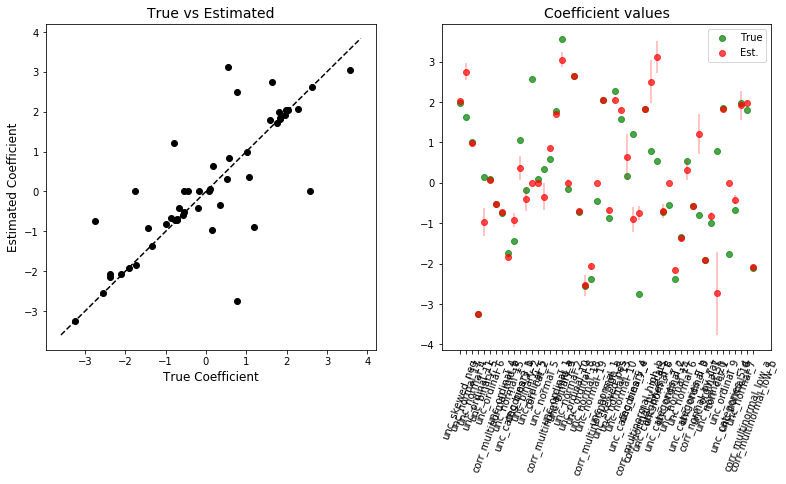

MAE: 		 32.38257
MSE: 		 1438.2414
Max Error: 	 92.61606
Expl Variance: 	 0.93348


In [31]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

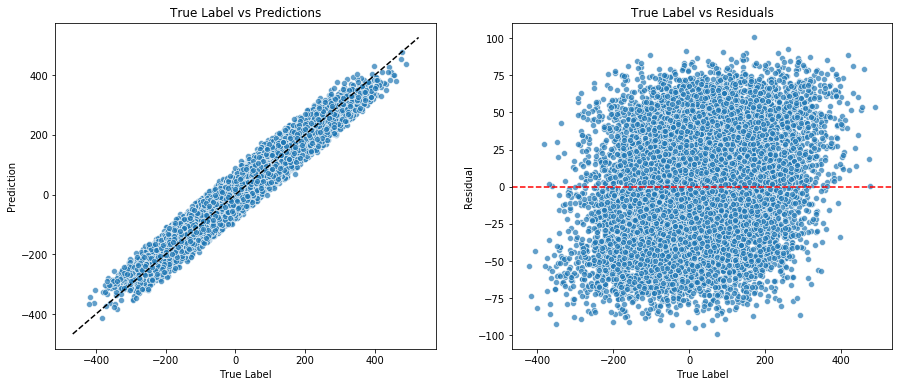

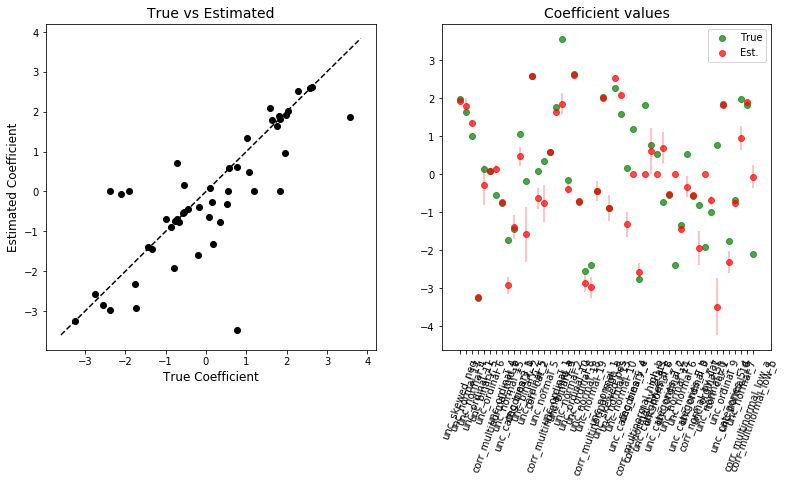

MAE: 		 34.04622
MSE: 		 1597.26373
Max Error: 	 100.44207
Expl Variance: 	 0.92625


In [32]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

We see how dropping only 5 features is enough for the model to be compromised and how the effect of adding extra features is bigger.

## 10 features

We can now turn our attention to a situation where only a few features are really useful to predict the target. In particular, the next experiments will deal with a target generated by a linear combination of **10 features**. Again, let's use exactly the right features to get a baseline.

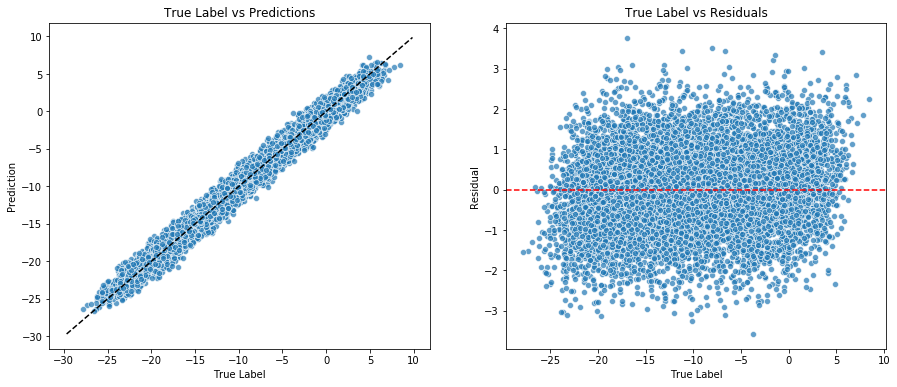

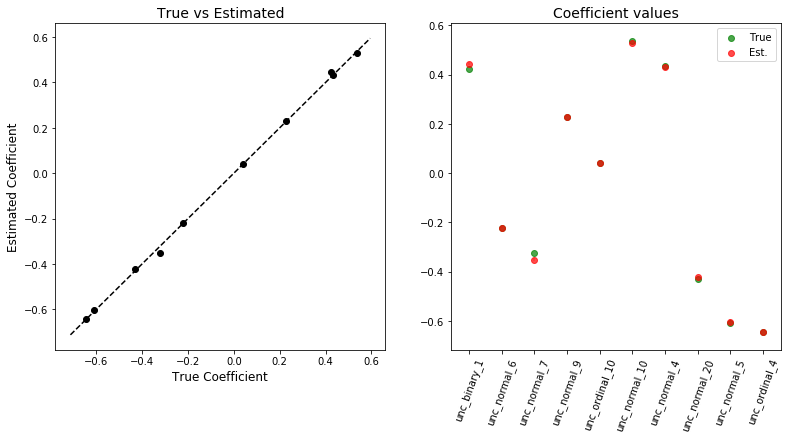

MAE: 		 0.80106
MSE: 		 1.00356
Max Error: 	 3.76193
Expl Variance: 	 0.98244


In [33]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

We see some imprecisions in the coefficient estimates that gets even bigger if we reduce the number of instances.

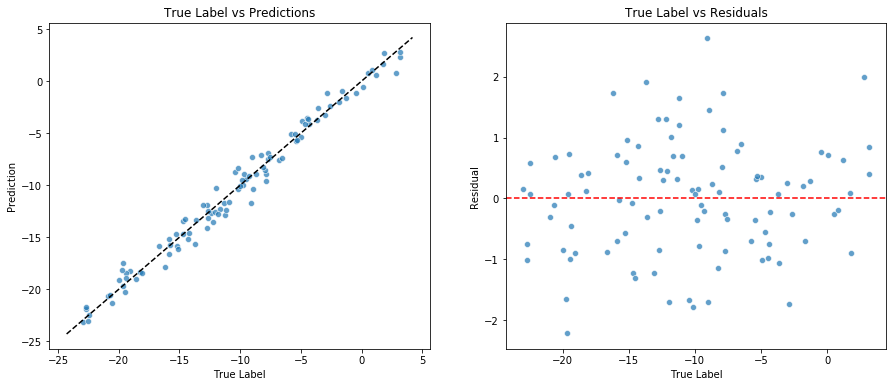

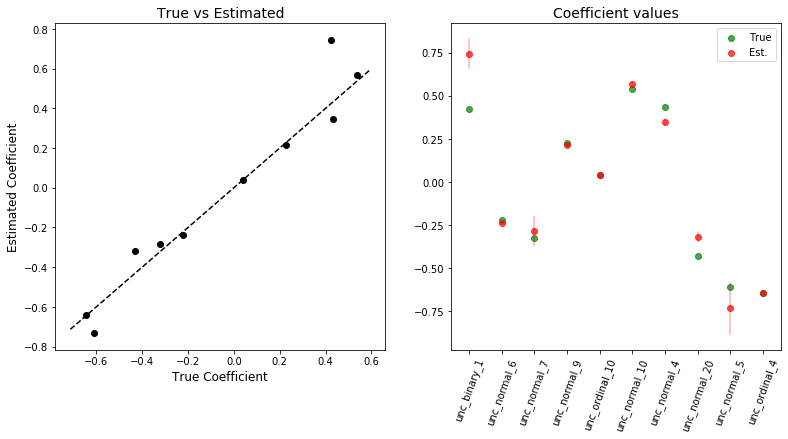

MAE: 		 0.74071
MSE: 		 0.86424
Max Error: 	 2.63515
Expl Variance: 	 0.98131


In [34]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

But completely disappears if we use all 100k available observations.

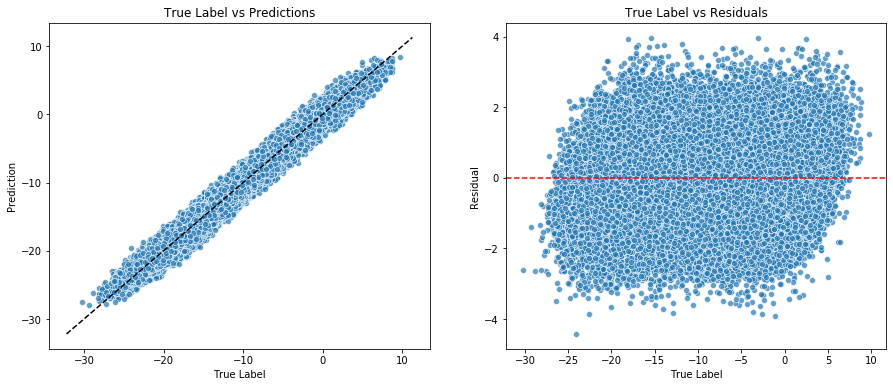

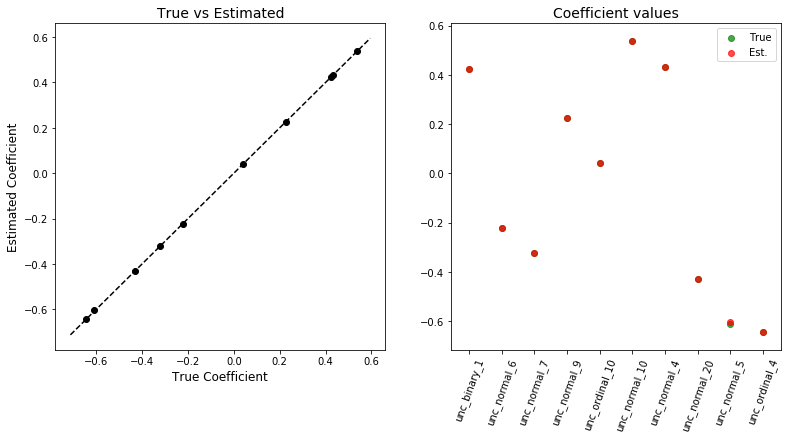

MAE: 		 0.79702
MSE: 		 0.9979
Max Error: 	 4.41547
Expl Variance: 	 0.98249


In [35]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=False, 
         store=False, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

If we then allow the model to train on all the available features (thus on 90 extra features), we get

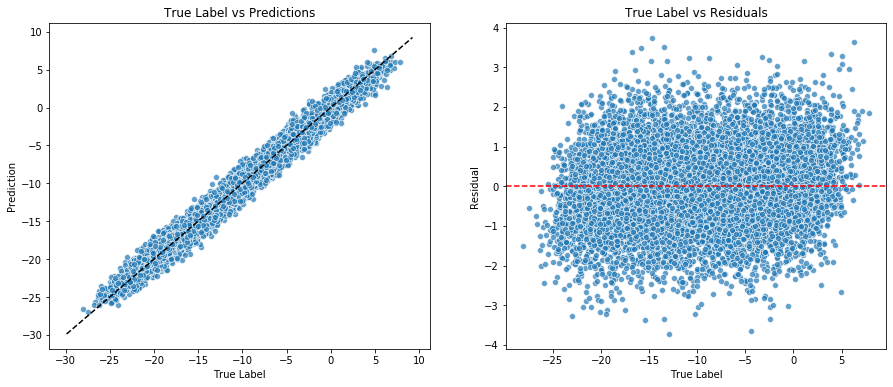

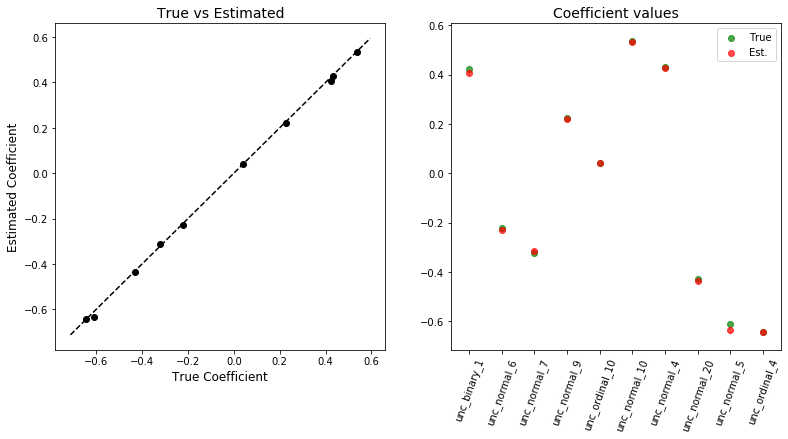

MAE: 		 0.79791
MSE: 		 1.00474
Max Error: 	 3.74225
Expl Variance: 	 0.98237


In [36]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

We see again that the model is fundamentally behaving in the same way, even estimating the coefficients better. It is good to keep in mind that the plot shows only the true coefficients that were used to generate the target, not all the coefficients the model has. Some (more or less) accidental correlation with other features potentially made the estimate more accurate.

If instead of having more features than necessary, we have fewer, we get to the following two situations.

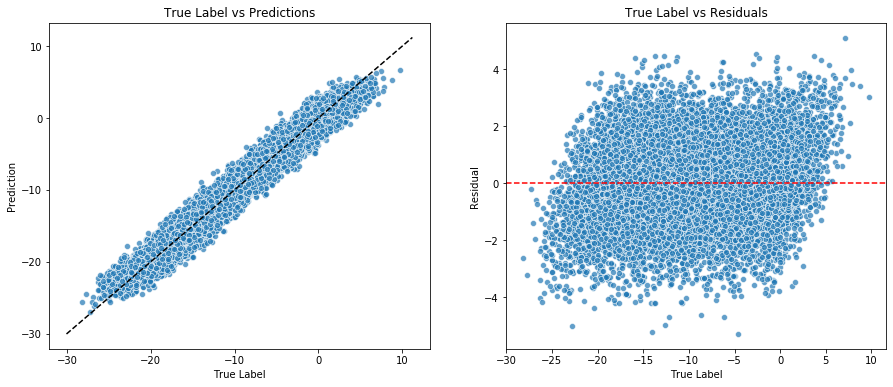

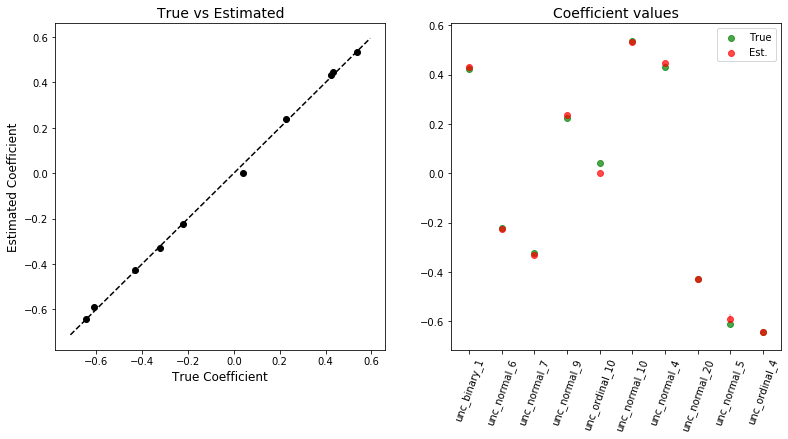

MAE: 		 1.27889
MSE: 		 2.4494
Max Error: 	 5.27009
Expl Variance: 	 0.95659


In [37]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

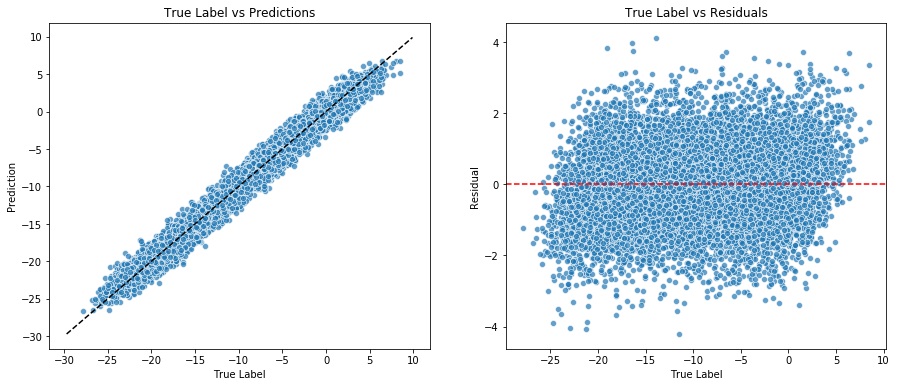

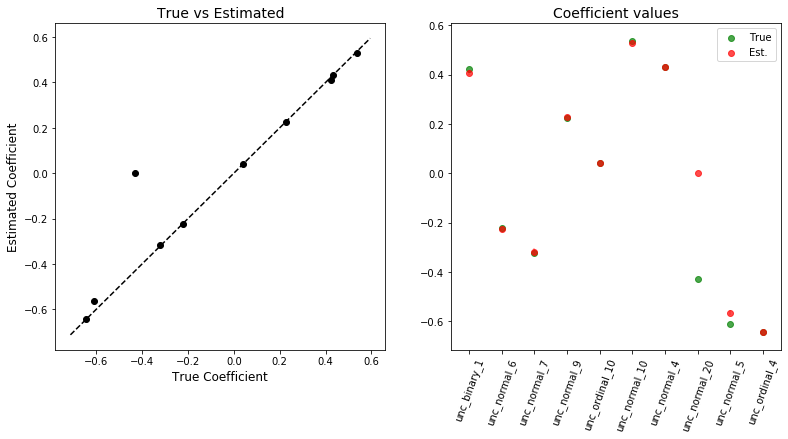

MAE: 		 0.9059
MSE: 		 1.2843
Max Error: 	 4.1965
Expl Variance: 	 0.97752


In [38]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

The model again has a worse performance but this time we see that the effects of losing 10% of the available features (i.e. 1 feature) were much smaller than the previous examples.

## Non-linear relations

At last, we can test the LinearRegression against something that is not supposed to be predicted via linear regression: a target generated by a **non-linear combination** of features.

As the coefficients (see notebook 1) are related to features that have different names in the data, we won't be able to study what happens with only the right features. The only option is to have them all for now.

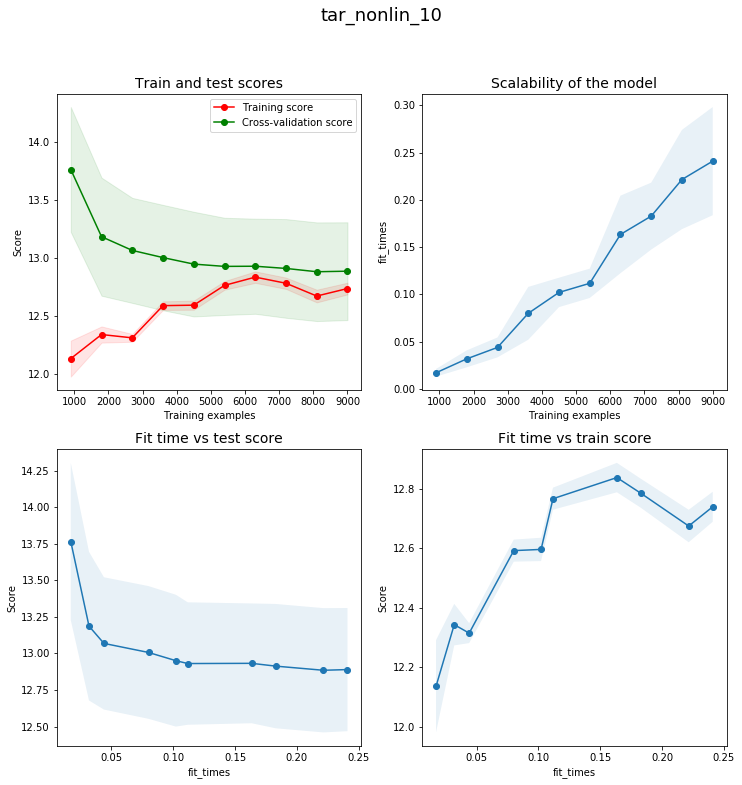

In [39]:
learning_curve(model, target_name='tar_nonlin_10', features='all', sample=10000, kfolds=kfolds)

The learning curve shows that the model has margins of improvement by simply providing more observations. However, we can see that the predictions are not as bad as one would expect.

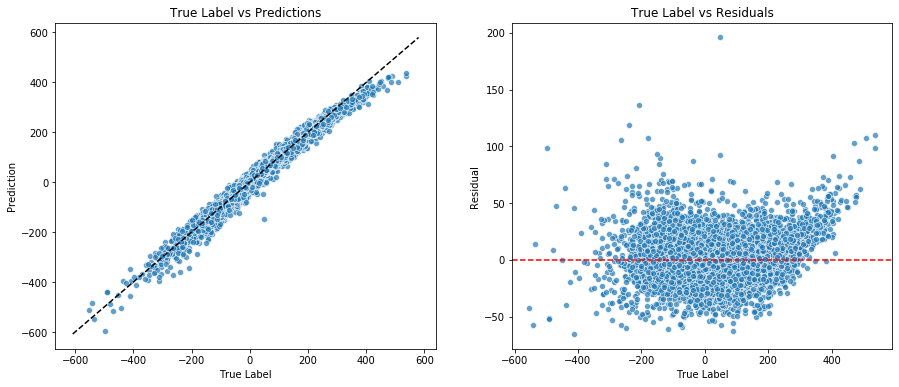

MAE: 		 12.89865
MSE: 		 308.69167
Max Error: 	 195.83981
Expl Variance: 	 0.97948


In [40]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name='LinearRegression')

We can also see that the model performance deteriorates much more with respect to the previous examples if we provide only 100 observations.

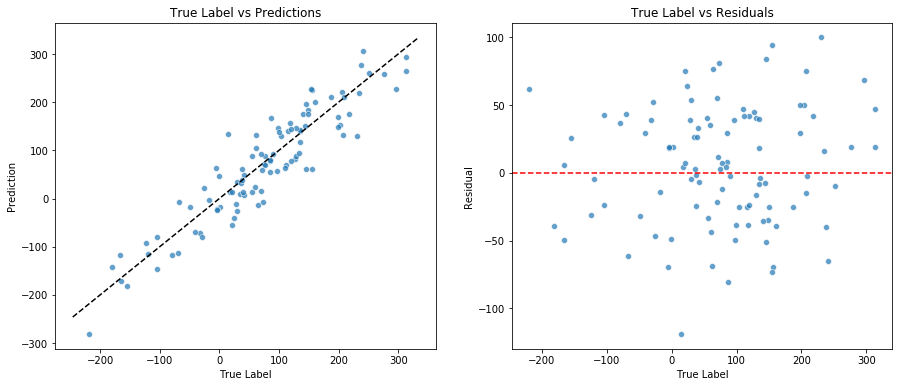

MAE: 		 36.45804
MSE: 		 1935.22562
Max Error: 	 119.01314
Expl Variance: 	 0.84397


In [41]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name='LinearRegression')

# Real application - HousePrice

All these simulated dataset are very handy to monitor the model behavior in a very controlled situation. One may then wonder how a simple model like this one behaves with more realistic datasets. For example, we can look at the HousePrice competition data.

As the goal here is not to get the highest possible result in this famous Kaggle competition, we will simply use a generic pipeline [developed in this notebook](https://www.kaggle.com/lucabasa/houseprice-end-to-end-project) and store the result to then compare it with the performance of more complex algorithms

In [42]:
model = ('linear', LinearRegression())
params = {'default'}

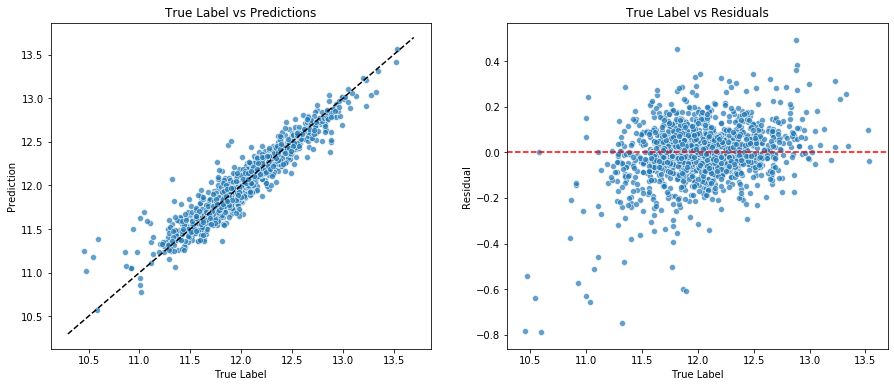

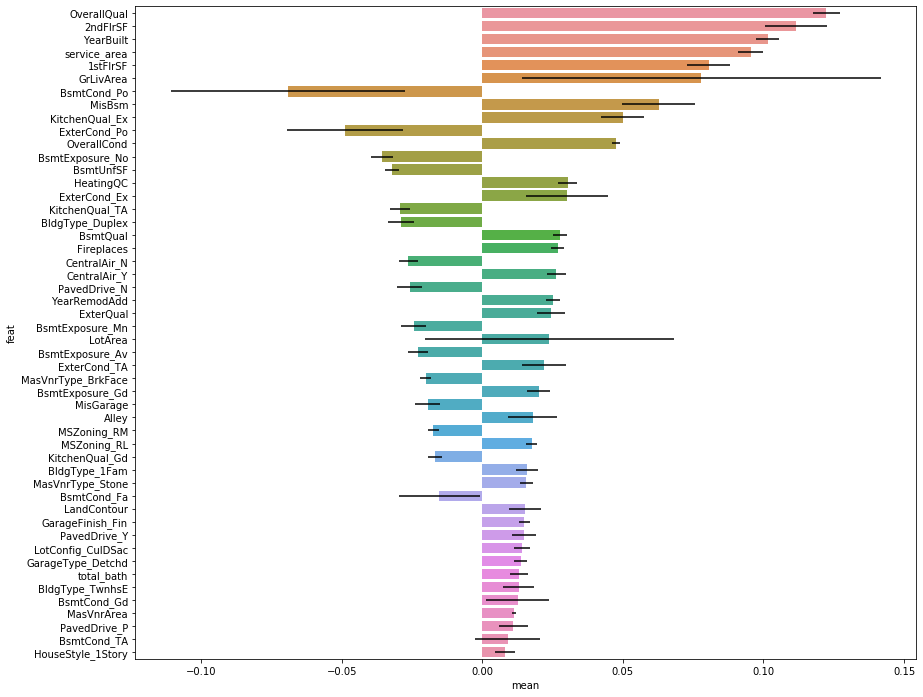

MAE: 		 0.08473
MSE: 		 0.01498
Max Error: 	 0.78623
Expl Variance: 	 0.90615


In [43]:
make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='LinearRegression')

Not too bad in terms of performance, but we immediately see that the coefficient of an important feature like `GrLivArea` has a very big uncertainty. One of the reasons is that the data flowing into the model suffer from multicollinearity, which generally leads to poor coefficients' estimates.

We will see how introducing a regularizing term in the model will influence this situation.

# Conclusion

`LinearRegression` is a very simple and useful algorithm that can achieve reasonable results on many datasets. It is also a very quick algorithm that scales linearly with the number of observations and quadratically with the number of features. This means that with many features the training time can become too long and it becomes preferable to use other approaches.

We have seen how a model can make the right predictions but not capturing the right contribution from each feature, which is something to keep in mind when developing a ML solution as this aspect greatly influences how the model will behave on truly unseen data.

Before moving to the next linear model, let's summarise some of the results using what we stored after each experiment

In [44]:
df = pd.read_csv('data/01_linear_models.csv')
df = df[df.Model=='LinearRegression'].copy()
df.head()

Date             Model Parameters                      Target  \
0  10/02/2020  LinearRegression    default      10_feat_10_inf_nonoise   
1  10/02/2020  LinearRegression    default        10_feat_10_inf_noise   
2  10/02/2020  LinearRegression    default       100_feat_65_inf_noise   
3  10/02/2020  LinearRegression    default  100_feat_65_inf_noise_rank   
4  10/02/2020  LinearRegression    default        10_feat_10_inf_noise   

  Variables  N_instances           MAE           MSE     Max_error  \
0       all       100000  2.042629e-13  8.523916e-26  2.280842e-12   
1       all       100000  1.591596e+02  3.990346e+04  8.707855e+02   
2       all       100000  3.595179e+02  2.026334e+05  1.939613e+03   
3       all       100000  6.386431e-01  6.396098e-01  3.437381e+00   
4       all          300  1.558184e+02  4.243773e+04  7.172868e+02   

   Explained_var  
0       1.000000  
1       0.553371  
2       0.489070  
3       0.531453  
4       0.566957

In [45]:
df[df.Target == 'tar_lin_full']

Date             Model Parameters        Target   Variables  \
7  10/02/2020  LinearRegression    default  tar_lin_full         all   
8  10/02/2020  LinearRegression    default  tar_lin_full         all   
9  10/02/2020  LinearRegression    default  tar_lin_full  unobserved   

   N_instances        MAE          MSE  Max_error  Explained_var  
7        10000   7.948790    99.288679  49.817617       0.970044  
8          100  29.546323  1290.035447  84.282447       0.721207  
9        10000  15.702497   359.351216  61.899745       0.890114

With a target generated linearly with 100 features we observe that

* Moving from 10000 to 100 observations leads to +150% in MAE, +608% in MSE, +90% in Max Error, and -20% in explained variance. The coefficients' estimates got much worse.
* Removing 10% of the features leads to +87% in MAE, +261% in MSE, +45% in Max Error, and -8% in explained variance. The coefficients got estimated in a similar way.

In [46]:
df[df.Target == 'tar_lin_half']

Date             Model Parameters        Target   Variables  \
10  10/02/2020  LinearRegression    default  tar_lin_half       exact   
11  10/02/2020  LinearRegression    default  tar_lin_half       exact   
12  10/02/2020  LinearRegression    default  tar_lin_half         all   
13  10/02/2020  LinearRegression    default  tar_lin_half         all   
14  10/02/2020  LinearRegression    default  tar_lin_half    exact-10   
15  10/02/2020  LinearRegression    default  tar_lin_half  unobserved   

    N_instances        MAE          MSE   Max_error  Explained_var  
10        10000   7.997467   100.070326   34.927793       0.995484  
11          100  12.912247   260.529268   39.502017       0.989019  
12        10000   8.017796   101.701586   39.314584       0.995317  
13          100  28.588341  1284.089473  101.458881       0.932526  
14        10000  32.382569  1438.241399   92.616057       0.933476  
15        10000  34.046219  1597.263729  100.442067       0.926250

With a target generated linearly with 50 features we observe that

* Moving from 10000 to 100 observation leads to +25% in MAE, +67% of MSE, -23% in Max Error, and nearly identical explained variance. Worse coefficients' estimates.
* If we add 50 extra features, we get a very similar perfomance but if we also reduce the number of features we then observe +225% in MAE, +953% in MSE, +129% in Max Error, and -6% in explained variance. Similar coefficients' estimates in the first case, much worse when we have fewer observations.
* Removing 5 features leads to +300% in MAE, +1327% in MSE, +136% in Max Error, and -6% in Explained variance. The coefficients' estimates got somewhat worse.
* Adding other 50 extra variables does not change the situation of the previous point.

In [47]:
df[df.Target == 'tar_lin_10']

Date             Model Parameters      Target   Variables  \
16  10/02/2020  LinearRegression    default  tar_lin_10       exact   
17  10/02/2020  LinearRegression    default  tar_lin_10       exact   
18  10/02/2020  LinearRegression    default  tar_lin_10         all   
19  10/02/2020  LinearRegression    default  tar_lin_10    exact-10   
20  10/02/2020  LinearRegression    default  tar_lin_10  unobserved   

    N_instances       MAE       MSE  Max_error  Explained_var  
16        10000  0.801059  1.003555   3.761931       0.982437  
17          100  0.740711  0.864243   2.635154       0.981307  
18        10000  0.797911  1.004742   3.742246       0.982372  
19        10000  1.278886  2.449396   5.270086       0.956594  
20        10000  0.905897  1.284305   4.196497       0.977523

With a target generated linearly with 10 features we observe that

* For the first time, reducing the observations improves the perfomance metrics.
* Adding 90 extra featurs doesn't seem to affect the performance too much
* Removing 1 feature leads to +50% in MAE, +140% in MSE, +47% in Max Error, -3% in Explained variance
* Situation partially restored when we introduce the 90 extra features again.

In all cases, the model estimated the coefficients well.

In [48]:
df[df.Target == 'tar_nonlin_10']

Date             Model Parameters         Target Variables  \
21  10/02/2020  LinearRegression    default  tar_nonlin_10       all   
22  10/02/2020  LinearRegression    default  tar_nonlin_10       all   

    N_instances        MAE          MSE   Max_error  Explained_var  
21        10000  12.898654   308.691672  195.839806       0.979476  
22          100  36.458039  1935.225625  119.013144       0.843971

With a target generated by a non linear combination of 10 features we see that

* reducing the observations to 100 leads to +255% in MAE, +953% in MSE, +4% in Max Error, -20% in explained variance